<a href="https://colab.research.google.com/github/quartermaine/Google-Colabs/blob/master/Malaria_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are going to train a Neural network in order to classify the malatria images dataset found in Kaggle.

#1) Donwloading and extracting data

First,  we are going to download the data using the Kaggle API and extract them to diffrent directories

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [28]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Oct 19 19:54 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [30]:
import os
print(os.listdir())

['.config', 'kaggle.json', 'cell_images', 'data', 'sample_data']


In [0]:
# make kaggle directory
!mkdir -p ~/.kaggle

In [32]:
# move kaggle.json to .kaggle directory
!mv /content/kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json
# set the path to /content
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [33]:
# make data directory 
!mkdir -p data
# Download dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p data 

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
import os
import zipfile
import random
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2 

print(tf.__version__)



1.15.0-rc3


In [0]:
# extract the files
local_zip = '/content/data/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data/cell-images')
zip_ref.close()

In [36]:
print(len(os.listdir('data/cell-images/cell_images/Parasitized')))
print(len(os.listdir('data/cell-images/cell_images/Uninfected')))

13780
13780


In [0]:
# Use os.mkdir to create your directories
# You will need a directory for parasitized-vs-uninfected, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    # make train and test directories
    os.mkdir("cell_images")
    os.mkdir("cell_images/parasitized-v-uninfected")
    os.mkdir('cell_images/parasitized-v-uninfected/training')
    os.mkdir('cell_images/parasitized-v-uninfected/testing')
    os.mkdir('cell_images/parasitized-v-uninfected/training/parasitized')
    os.mkdir('cell_images/parasitized-v-uninfected/training/uninfected')
    os.mkdir('cell_images/parasitized-v-uninfected/testing/parasitized')
    os.mkdir('cell_images/parasitized-v-uninfected/testing/uninfected')
except OSError:
    pass

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

  

PARASITIZED_SOURCE_DIR = "data/cell-images/cell_images/Parasitized/"
TRAINING_PARASITIZED_DIR = "cell_images/parasitized-v-uninfected/training/parasitized/"
TESTING_PARASITIZED_DIR = "cell_images/parasitized-v-uninfected/testing/parasitized/"
UNINFECTED_SOURCE_DIR = "data/cell-images/cell_images/Uninfected/"
TRAINING_UNINFECTED_DIR = "cell_images/parasitized-v-uninfected/training/uninfected/"
TESTING_UNINFECTED_DIR = "cell_images/parasitized-v-uninfected/testing/uninfected/"

split_size = .9
split_data(PARASITIZED_SOURCE_DIR, TRAINING_PARASITIZED_DIR, TESTING_PARASITIZED_DIR, split_size)
split_data(UNINFECTED_SOURCE_DIR, TRAINING_UNINFECTED_DIR, TESTING_UNINFECTED_DIR, split_size)

In [41]:
print(len(os.listdir('cell_images/parasitized-v-uninfected/training/parasitized/')))
print(len(os.listdir('cell_images/parasitized-v-uninfected/training/uninfected/')))
print(len(os.listdir('cell_images/parasitized-v-uninfected/testing/parasitized/')))
print(len(os.listdir('cell_images/parasitized-v-uninfected/testing/uninfected')))

# Expected output:


13644
13641
2622
2621


In [0]:
train_parasitized_dir='cell_images/parasitized-v-uninfected/training/parasitized/'
train_uninfected_dir='cell_images/parasitized-v-uninfected/training/uninfected/'

train_parasitized_fnames = os.listdir( train_parasitized_dir )
train_uninfected_fnames = os.listdir( train_uninfected_dir )

# 2) Plotting some images 

In [0]:
%matplotlib inline

nrows = 4
ncols = 4


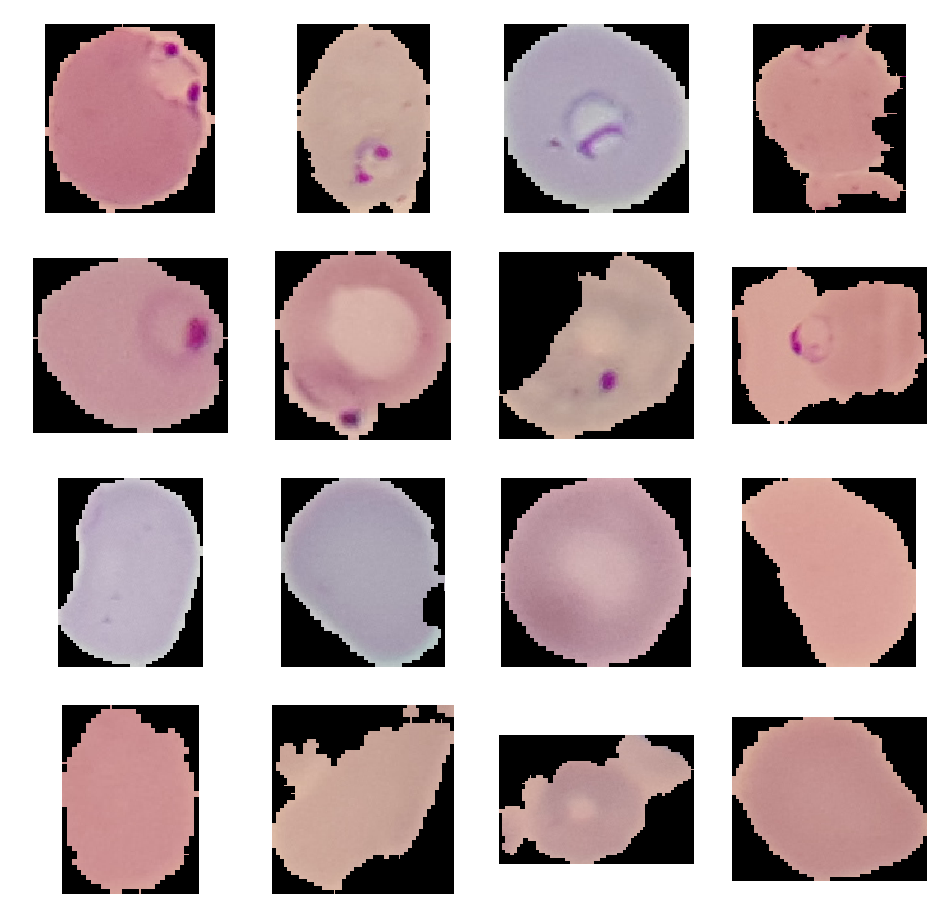

In [0]:


fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index=8

next_parasitized_pix = [os.path.join(train_parasitized_dir, fname) 
                for fname in train_parasitized_fnames[ pic_index-8:pic_index] 
               ]

next_uninfected_pix = [os.path.join(train_uninfected_dir, fname) 
                for fname in train_uninfected_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_parasitized_pix+next_uninfected_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  if i<8:
    plt.title("image for : parasitized",color = 'white', size=14)
  else :
    plt.title("image for : uninfected",color = 'white', size=14)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#3) Define model and Data augmentation

Next we need to define the model and we are going to use data augmentation(optional since the images don't have lots of features)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [51]:
TRAINING_DIR ="cell_images/parasitized-v-uninfected/training/" 
TESTING_DIR='cell_images/parasitized-v-uninfected/testing/'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150),
                                                    subset="training")


validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150),
                                                              subset="validation")


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
            target_size=(150, 150), class_mode='binary')


print('\nClasses dictionary:')

print(train_generator.class_indices)

Found 21827 images belonging to 2 classes.
Found 5456 images belonging to 2 classes.
Found 5241 images belonging to 2 classes.

Classes dictionary:
{'parasitized': 0, 'uninfected': 1}


#4) Train the model

Next we train our model and specify early stopping 

In [47]:
#save_model_path = '/tmp/weights.hdf5'
#cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 50,
    validation_data = validation_generator, 
    validation_steps = 30,
    epochs = 100,
    verbose = 1,
    callbacks = [earlystop])


Epoch 1/100
50/50 [==============================] - 52s 1s/step - loss: 1.1212 - acc: 0.5277 - val_loss: 0.6861 - val_acc: 0.5687
Epoch 2/100
50/50 [==============================] - 47s 936ms/step - loss: 0.6902 - acc: 0.5564 - val_loss: 0.6944 - val_acc: 0.5000
Epoch 3/100
50/50 [==============================] - 46s 915ms/step - loss: 0.6595 - acc: 0.6096 - val_loss: 0.7177 - val_acc: 0.5557
Epoch 4/100
50/50 [==============================] - 46s 921ms/step - loss: 0.5435 - acc: 0.7582 - val_loss: 0.4391 - val_acc: 0.8233
Epoch 5/100
50/50 [==============================] - 45s 902ms/step - loss: 0.3965 - acc: 0.8468 - val_loss: 0.4034 - val_acc: 0.8603
Epoch 6/100
50/50 [==============================] - 46s 916ms/step - loss: 0.4070 - acc: 0.8638 - val_loss: 0.3933 - val_acc: 0.8873
Epoch 7/100
50/50 [==============================] - 45s 909ms/step - loss: 0.3113 - acc: 0.8924 - val_loss: 0.3573 - val_acc: 0.8967
Epoch 8/100
50/50 [==============================] - 45s 906ms/st

#5) Plots and Model Evaluation

We are going to evaluate the model using the test data and make plots for train and validation accuracy

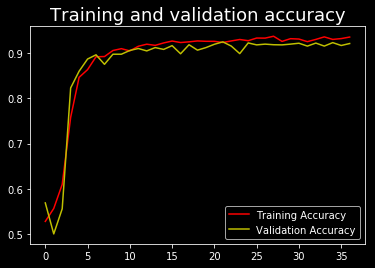

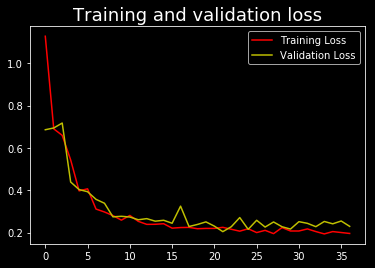

In [49]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use(['dark_background', 'seaborn-dark-palette'])

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'y', label = "Validation Accuracy")
plt.title('Training and validation accuracy', color='white', size=18)
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'y', label = "Validation Loss")
plt.title('Training and validation loss', color='white', size=18)
plt.legend(loc=0)



In [52]:

print("Accuracy on test data : {0:.2f}%".format(model.evaluate(test_generator,verbose=False)[1]))

Accuracy on test data : 0.96%


#6) Predictions on the test data

In [0]:
test_parasitized_dir='cell_images/parasitized-v-uninfected/testing/parasitized/'
test_uninfected_dir='cell_images/parasitized-v-uninfected/testing/uninfected/'

test_parasitized_fnames = os.listdir( test_parasitized_dir )
test_uninfected_fnames = os.listdir( test_uninfected_dir )



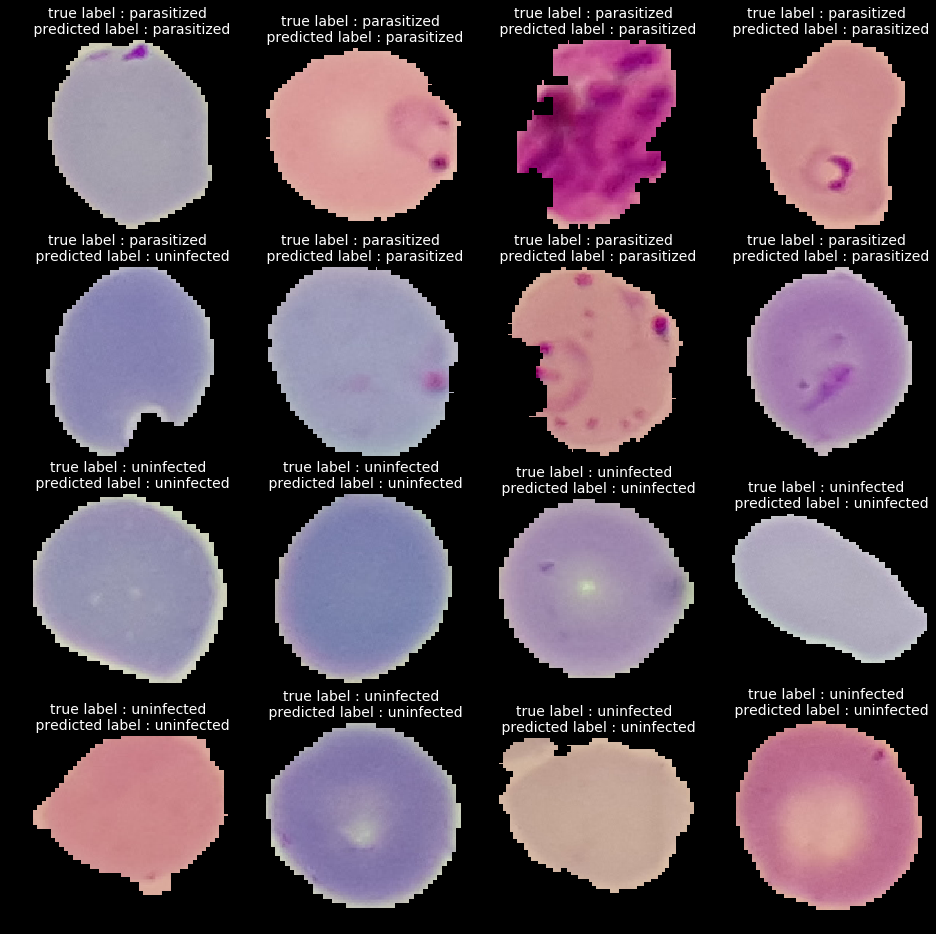

In [55]:
nrows = 4
ncols = 4


fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index=100

next_parasitized_pix = [os.path.join(test_parasitized_dir, fname) 
                for fname in test_parasitized_fnames[ pic_index-8:pic_index] 
               ]

next_uninfected_pix = [os.path.join(test_uninfected_dir, fname) 
                for fname in test_uninfected_fnames[ pic_index-8:pic_index]
               ]

labels=['parasitized', 'uninfected']


d1=[]

for image in next_parasitized_pix:
  img = cv2.imread(image)
  res = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
  res = res / 255.
  x = np.expand_dims(res, axis=0)

  if x.shape==(1,150, 150, 3):
    clas = model.predict(x)
    if clas[0]<0.5:
      indx=0
    else:
      indx=1
    d1.append(labels[indx])
    
    
d2=[]

for image in next_uninfected_pix:
  img = cv2.imread(image)
  res = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
  res = res / 255.
  x = np.expand_dims(res, axis=0)

  if x.shape==(1,150, 150, 3):
    clas = model.predict(x)
    if clas[0]<0.5:
      indx=0
    else:
      indx=1
    d2.append(labels[indx])
  
    
    
d1.extend(d2)


for i, img_path in enumerate(next_parasitized_pix+next_uninfected_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  if i<8:
    plt.title("true label : parasitized \n predicted label : {}".format(d1[i])
              ,color = 'white', size=14)
  else :
    plt.title("true label : uninfected \n predicted label : {}".format(d1[i])
              ,color = 'white', size=14)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# 7) References

The wonderfull specialization Tensorflow in Practice in coursera with Laurence Moroney.